In [1]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import chart_studio.tools
import chart_studio.plotly as py

In [2]:
%%time
# Get all rows of referrals_geo together with communities from Louvain algorithm
query = """
     
     SELECT *
     FROM referrals_geo
     LEFT JOIN communities_from
         USING (from_npi)
     LEFT JOIN communities_to
         USING (to_npi)
     LEFT JOIN affiliations_from
         USING (from_npi)
     LEFT JOIN affiliations_to
         USING (to_npi)

"""

with sqlite3.connect('data/hopteam_broad.sqlite') as db:
    all_fields = pd.read_sql(query, db)
    
all_fields

CPU times: user 4.24 s, sys: 325 ms, total: 4.57 s
Wall time: 4.82 s


,from_npi,referral_id,entity_from,name_from,organization_from,taxonomy_code_from,classification_from,specialization_from,address_line1_from,address_line2_from,...,address_to,lat_from,lng_from,lat_to,lng_to,distance_miles,from_communityid,to_communityid,affiliation_from,affiliation_to
0,1821080961,18854880,1.0,"SHERWOOD, WILLIAM",None,207Q00000X,Family Medicine,None,302 N CONGRESS BLVD,None,...,"400 E PUBLIC SQUARE, ALEXANDRIA, TN 37012",35.969171,-85.807472,36.077559,-86.033322,14.665166,20624.0,20624.0,NOT IN NASHVILLE,NO MAJOR AFFILIATION/OTHER
1,1679677199,104890727,2.0,None,"CRIPPS, HOOPER & RHODY, PLLC",207Q00000X,Family Medicine,None,302 N CONGRESS BLVD,None,...,"400 E PUBLIC SQUARE, ALEXANDRIA, TN 37012",35.969171,-85.807472,36.077559,-86.033322,14.665166,NaN,20624.0,NOT IN NASHVILLE,NO MAJOR AFFILIATION/OTHER
2,1841282779,131966153,1.0,"RHODY, KEVIN",None,207Q00000X,Family Medicine,None,302 N CONGRESS BLVD,None,...,"400 E PUBLIC SQUARE, ALEXANDRIA, TN 37012",35.969171,-85.807472,36.077559,-86.033322,14.665166,20624.0,20624.0,NOT IN NASHVILLE,NO MAJOR AFFILIATION/OTHER
3,1770575607,146169993,1.0,"COOPER, STEVEN",None,207Q00000X,Family Medicine,None,302 N CONGRESS BLVD,None,...,"400 E PUBLIC SQUARE, ALEXANDRIA, TN 37012",35.969171,-85.807472,36.077559,-86.033322,14.665166,20624.0,20624.0,NOT IN NASHVILLE,NO MAJOR AFFILIATION/OTHER
4,1093741464,29450644,2.0,None,"ADVANCED DIAGNOSTIC IMAGING, PC",207R00000X,Internal Medicine,None,3024 BUSINESS PARK CIR,None,...,"400 E PUBLIC SQUARE, ALEXANDRIA, TN 37012",36.332108,-86.700830,36.077559,-86.033322,41.132856,NaN,20624.0,HCA,NO MAJOR AFFILIATION/OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240562,1245257005,191055279,2.0,None,CARDIOLOGY AND INTERNAL MEDICINE GROUP OF NORT...,207R00000X,Internal Medicine,None,155 AVENUE E,None,...,"1510 HATCHER LN, SUITE 1, COLUMBIA, TN 38401",29.721553,-84.991627,35.603333,-87.061742,423.526420,NaN,NaN,NOT IN NASHVILLE,NOT IN NASHVILLE
240563,1245623701,191233185,2.0,None,L & K HEALTH SERVICES,363LF0000X,Nurse Practitioner,Family,1004 HICKORY HILL LN,SUITE 106,...,"1324 TROTWOOD AVE STE 1, COLUMBIA, TN 38401",36.189579,-86.629045,35.600876,-87.072753,47.624578,NaN,NaN,NO MAJOR AFFILIATION/OTHER,NOT IN NASHVILLE
240564,1205875713,184518074,2.0,None,ACCELERATED REHABILITATION CENTERS LTD,225100000X,Physical Therapist,None,600 OAKMONT LN STE 600C,None,...,"1810 SHADY BROOK ST STE 4, COLUMBIA, TN 38401",41.821708,-87.960959,35.602084,-87.057549,432.176893,NaN,NaN,NOT IN NASHVILLE,NOT IN NASHVILLE
240565,1558441311,31085666,2.0,None,KAU HOSPITAL,282NC0060X,General Acute Care Hospital,Critical Access,1 KAMANI STREET,None,...,"166 FIFTH RD, SUMMERTOWN, TN 38483",19.199622,-155.472070,35.484525,-87.341322,4245.485254,NaN,NaN,NOT IN NASHVILLE,NOT IN NASHVILLE


In [ ]:
plt.figure(figsize=(20,10))
c= all_fields.corr() 
sns.heatmap(c[(c >= 0.4) | (c <= -0.4)], cmap= 'BrBG' , annot=True)
c
#

In [ ]:
affiliations = all_fields[['affiliation_from','affiliation_to']].value_counts()
affiliations = affiliations.to_frame()
affiliations.nlargest(10, columns = affiliations)

In [ ]:
pd.crosstab(all_fields['affiliation_from'], 
            all_fields['affiliation_to'], normalize = 'index').plot(kind = 'bar', 
                                    edgecolor = 'black', 
                                    width = 0.75,
                                    stacked = True,
                                    figsize = (12,8))
plt.ylabel('Counts');
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left');

In [3]:
filtered_fields = all_fields[['from_npi',
                              'referral_id',
                              'name_from',
                              'organization_from',
                              'classification_from',
                              'to_npi',
                              'name_to',
                              'organization_to',
                              'classification_to',
                              'from_communityid',
                              'to_communityid',
                              'affiliation_from',
                              'affiliation_to',
                              'patient_count',
                              'transaction_count', 
                              'average_day_wait',
                              'std_day_wait' ]]
filtered_fields = (filtered_fields.dropna(subset = ['from_communityid', 'to_communityid'])
                  )
filtered_fields = filtered_fields.drop(columns = 'to_communityid')
filtered_fields = filtered_fields.rename(columns = {'from_communityid':'communityid'})
filtered_fields = filtered_fields[((filtered_fields['classification_to']!='Radiology') 
                                   & (filtered_fields['classification_to']!='Emergency')
                                   & (filtered_fields['classification_to']!='Pathology') 
                                   & (filtered_fields['classification_to']!='Laboratory')
                                   & (filtered_fields['classification_to']!='Anesthesiology'))]

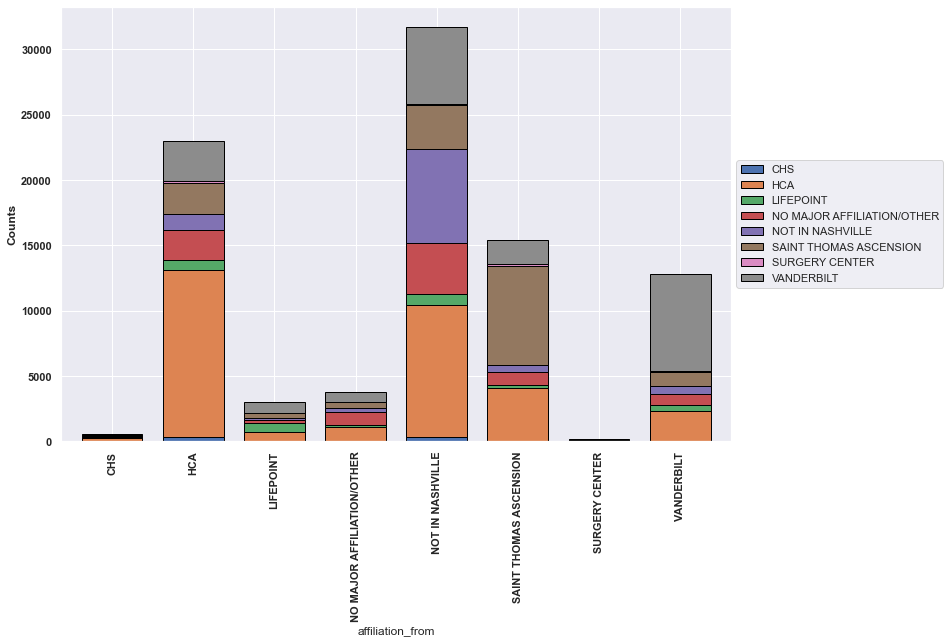

In [57]:
pd.crosstab(filtered_fields['affiliation_from'], 
            filtered_fields['affiliation_to']).plot(kind = 'bar', 
                                    edgecolor = 'black', 
                                    width = 0.75,
                                    stacked = True,
                                    figsize = (12,8))

plt.ylabel('Counts', fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')
plt.xticks(fontweight = 'bold');

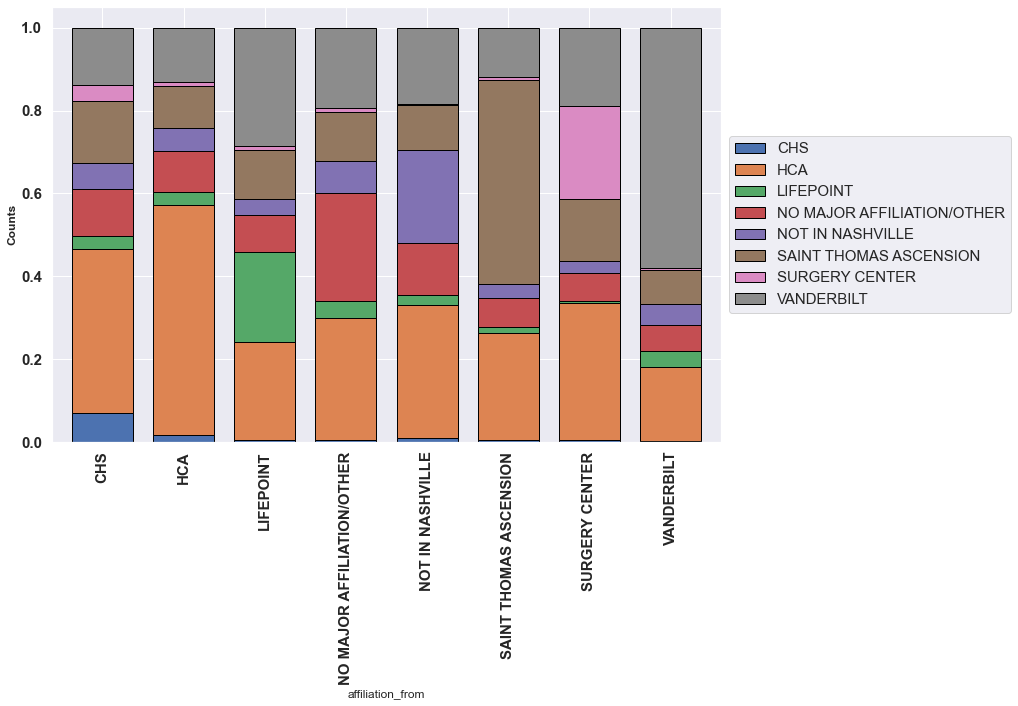

In [17]:
pd.crosstab(filtered_fields['affiliation_from'], 
            filtered_fields['affiliation_to'], normalize = 'index').plot(kind = 'bar', 
                                    edgecolor = 'black', 
                                    width = 0.75,
                                    stacked = True,
                                    figsize = (12,8),
                                                                        fontsize = 15)

plt.ylabel('Counts', fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left',fontsize = 15)
plt.xticks(fontweight = 'bold');
#plt.savefig('data/affiliations.png');

In [4]:
crosstab = pd.crosstab(filtered_fields['affiliation_from'], 
            filtered_fields['affiliation_to'], normalize = 'index')

In [18]:
chart_studio.tools.set_credentials_file(username='james.a.gilbert', api_key='ojmzhFB4ylYBMMQwepbZ')

In [9]:
fig = px.bar(crosstab, labels={
                     "affiliation_from": "From Affiliation",
                     "value": "Percentage",
                     "affiliation_to": "Affiliation To"
                 },
                title="Percent of Referrals to Affiliations")
fig.update_layout(title_x = 0.5)
fig.show()

In [17]:
py.plot(fig, filename = 'affiliation_to', auto_open=True)

'https://plotly.com/~James.a.gilbert/1/'

In [35]:
#username = 'james.a.gilbert' # your username
#api_key = 'ojmzhFB4ylYBMMQwepbZ' # your api key - go to profile > settings > regenerate keychart_studio.tools.set_credentials_file(username=username, api_key=api_key)
chart_studio.tools.get_embed('https://plotly.com/~James.a.gilbert/1/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~James.a.gilbert/1.embed" height="525" width="100%"></iframe>'

In [11]:
crosstab2 = pd.crosstab(filtered_fields['affiliation_from'], 
            filtered_fields['affiliation_to'])

In [13]:
order = {'NOT IN NASHVILLE': [1],
         'HCA': [2],
         'SAINT THOMAS ASCENSION': [3],
         'VANDERBILT':[4],
         'NO MAJOR AFFILIATION/OTHER': [5],
         'LIFEPOINT': [6],
         'CHS': [7],
         'SURGERY CENTER': [8]}

In [15]:
fig2 = px.bar(crosstab2,labels={
                     "affiliation_from": "From Affiliation",
                     "value": "Total Patient Referrals",
                     "affiliation_to": "Affiliation To"
                 },
                title="Total Volume of Referrals to Affiliations", category_orders= order)
fig2.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, title_x = 0.5)
fig2.show()

In [16]:
py.plot(fig2, filename = 'affiliation_to_counts', auto_open=True)

'https://plotly.com/~James.a.gilbert/3/'

In [55]:
chart_studio.tools.get_embed('https://plotly.com/~James.a.gilbert/3/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~James.a.gilbert/3.embed" height="525" width="100%"></iframe>'

In [ ]:
plt.figure(figsize=(20,10))
c= filtered_fields.corr() 
sns.heatmap(c, cmap= 'BrBG' , annot=True)
c

In [ ]:
filtered_fields['communityid'].value_counts().nlargest(10)

In [ ]:
filtered_fields.groupby(['communityid']).sum().sort_values(by ='patient_count', ascending = False )